In [1]:
! pip install ppscore

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

import warnings
warnings.filterwarnings('ignore')

In [7]:
df= pd.read_csv("https://raw.githubusercontent.com/SukmaSuciyana/data1/main/marketing_campaign.csv", index_col=0)
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,635000,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,11000,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,426000,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,11000,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,173000,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,S1,Menikah,61223000.0,0,1,13-06-2013,46,709000,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,S3,Bertunangan,64014000.0,2,1,10-06-2014,56,406000,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,S1,Cerai,56981000.0,0,0,25-01-2014,91,908000,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,S2,Bertunangan,69245000.0,0,1,24-01-2014,8,428000,...,3,0,0,0,0,0,0,3,11,0


# Feature Engineering

Feature Engineering dengan menghitung conversion rate dengan definisi (#response / #visit). Tidak hanya conversion rate, namun juga cari feature lain yang representatif, contohnya seperti umur, jumlah anak, total pengeluaran, total transaksi, dll.

In [8]:
import numpy as np
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

df['age'] = 2022 - df['Year_Birth']
df['join_at_age'] = df['Dt_Customer'].dt.year - df['Year_Birth']
df['total_kids'] = df['Kidhome'] + df['Teenhome']
df['is_parents'] = np.where(df['total_kids'] > 0, 1, 0)

# age_range
df.loc[(df['age'] >= 0) & (df['age'] < 12), 'age_range'] = "child"
df.loc[(df['age'] >= 12) & (df['age'] < 18), 'age_range'] = "teens"
df.loc[(df['age'] >= 18) & (df['age'] < 36), 'age_range'] = "young_adults"
df.loc[(df['age'] >= 36) & (df['age'] < 55), 'age_range'] = "middle_aged_adults"
df.loc[(df['age'] >= 55), 'age_range'] = "older_adults"

# amount spent
df['total_amount_spent'] = df['MntCoke'] \
                              + df['MntFruits'] \
                              + df['MntMeatProducts'] \
                              + df['MntFishProducts'] \
                              + df['MntSweetProducts'] \
                              + df['MntGoldProds']

# accepted campaigns
df['total_accepted_campaign'] = df['AcceptedCmp1'] \
                                    + df['AcceptedCmp2'] \
                                    + df['AcceptedCmp3'] \
                                    + df['AcceptedCmp4'] \
                                    + df['AcceptedCmp5']

# total transaction purchased --- WE ASSUMED ALL OF THIS PURCHASES ARE MECE (mutually exclusive and collectively exhaustive)
df['total_transaction'] = df['NumDealsPurchases'] \
                            + df['NumWebPurchases'] \
                            + df['NumCatalogPurchases'] \
                            + df['NumStorePurchases']

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

df['cvr'] = df.apply(lambda x: safe_div(x['total_transaction'],x['NumWebVisitsMonth']), axis=1)

# **Exploratory Data Analysis**

## **Descriptive Statistics**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 0 to 2239
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       2240 non-null   int64         
 1   Year_Birth               2240 non-null   int64         
 2   Education                2240 non-null   object        
 3   Marital_Status           2240 non-null   object        
 4   Income                   2216 non-null   float64       
 5   Kidhome                  2240 non-null   int64         
 6   Teenhome                 2240 non-null   int64         
 7   Dt_Customer              2240 non-null   datetime64[ns]
 8   Recency                  2240 non-null   int64         
 9   MntCoke                  2240 non-null   int64         
 10  MntFruits                2240 non-null   int64         
 11  MntMeatProducts          2240 non-null   int64         
 12  MntFishProducts          2240 non-

In [10]:
# Melihat jumlah data
for col in df:
    print(f'''Value count kolom {col}:''')
    print(df[col].value_counts())
    print()

Value count kolom ID:
5524    1
6885    1
3478    1
7494    1
1763    1
       ..
5682    1
5564    1
6516    1
6255    1
9405    1
Name: ID, Length: 2240, dtype: int64

Value count kolom Year_Birth:
1976    89
1971    87
1975    83
1972    79
1978    77
1970    77
1973    74
1965    74
1969    71
1974    69
1956    55
1958    53
1979    53
1952    52
1977    52
1968    51
1959    51
1966    50
1954    50
1955    49
1960    49
1982    45
1963    45
1967    44
1962    44
1957    43
1951    43
1983    42
1986    42
1964    42
1980    39
1981    39
1984    38
1961    36
1953    35
1985    32
1989    30
1949    30
1950    29
1988    29
1987    27
1948    21
1990    18
1946    16
1947    16
1991    15
1992    13
1945     8
1943     7
1944     7
1993     5
1995     5
1994     3
1996     2
1899     1
1941     1
1893     1
1900     1
1940     1
Name: Year_Birth, dtype: int64

Value count kolom Education:
S1     1127
S3      486
S2      370
D3      203
SMA      54
Name: Education, dtype: int64


- Tidak ada data NULL
- Tidak ada data Duplikat
- Type data sudah sesuai
- Tidak ada data yang aneh

## **Statistical Summary**

In [11]:
numerical = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke',
                      'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                      'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                      'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                      'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue',
                      'age', 'join_at_age', 'total_kids', 'total_amount_spent'
                     ]

categorical = ['Education', 'Marital_Status',
                'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                'AcceptedCmp4', 'AcceptedCmp5', 'Complain',
                'Response', 'is_parents', 'age_range'
              ]

In [12]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2216.0,5.224725e+07,2.517308e+07,1730000.0,35303000.0,51381500.0,68522000.0,666666000.0
Kidhome,2240.0,4.441964e-01,5.383981e-01,0.0,0.0,0.0,1.0,2.0
Teenhome,2240.0,5.062500e-01,5.445382e-01,0.0,0.0,0.0,1.0,2.0
Recency,2240.0,4.910938e+01,2.896245e+01,0.0,24.0,49.0,74.0,99.0
MntCoke,2240.0,3.039357e+05,3.365974e+05,0.0,23750.0,173500.0,504250.0,1493000.0
MntFruits,2240.0,2.630223e+04,3.977343e+04,0.0,1000.0,8000.0,33000.0,199000.0
MntMeatProducts,2240.0,1.669500e+05,2.257154e+05,0.0,16000.0,67000.0,232000.0,1725000.0
MntFishProducts,2240.0,3.752545e+04,5.462898e+04,0.0,3000.0,12000.0,50000.0,259000.0
MntSweetProducts,2240.0,2.706295e+04,4.128050e+04,0.0,1000.0,8000.0,33000.0,263000.0
MntGoldProds,2240.0,4.402188e+04,5.216744e+04,0.0,9000.0,24000.0,56000.0,362000.0


In [13]:
df[categorical].describe().T

,count,mean,std,min,25%,50%,75%,max
AcceptedCmp1,2240.0,0.064286,0.245316,0.0,0.0,0.0,0.0,1.0
AcceptedCmp2,2240.0,0.013393,0.114976,0.0,0.0,0.0,0.0,1.0
AcceptedCmp3,2240.0,0.072768,0.259813,0.0,0.0,0.0,0.0,1.0
AcceptedCmp4,2240.0,0.074554,0.262728,0.0,0.0,0.0,0.0,1.0
AcceptedCmp5,2240.0,0.072768,0.259813,0.0,0.0,0.0,0.0,1.0
Complain,2240.0,0.009375,0.096391,0.0,0.0,0.0,0.0,1.0
Response,2240.0,0.149107,0.356274,0.0,0.0,0.0,0.0,1.0
is_parents,2240.0,0.715179,0.451430,0.0,0.0,1.0,1.0,1.0


## **Bivariate Analysis**

### Correlation Plot

<Axes: >

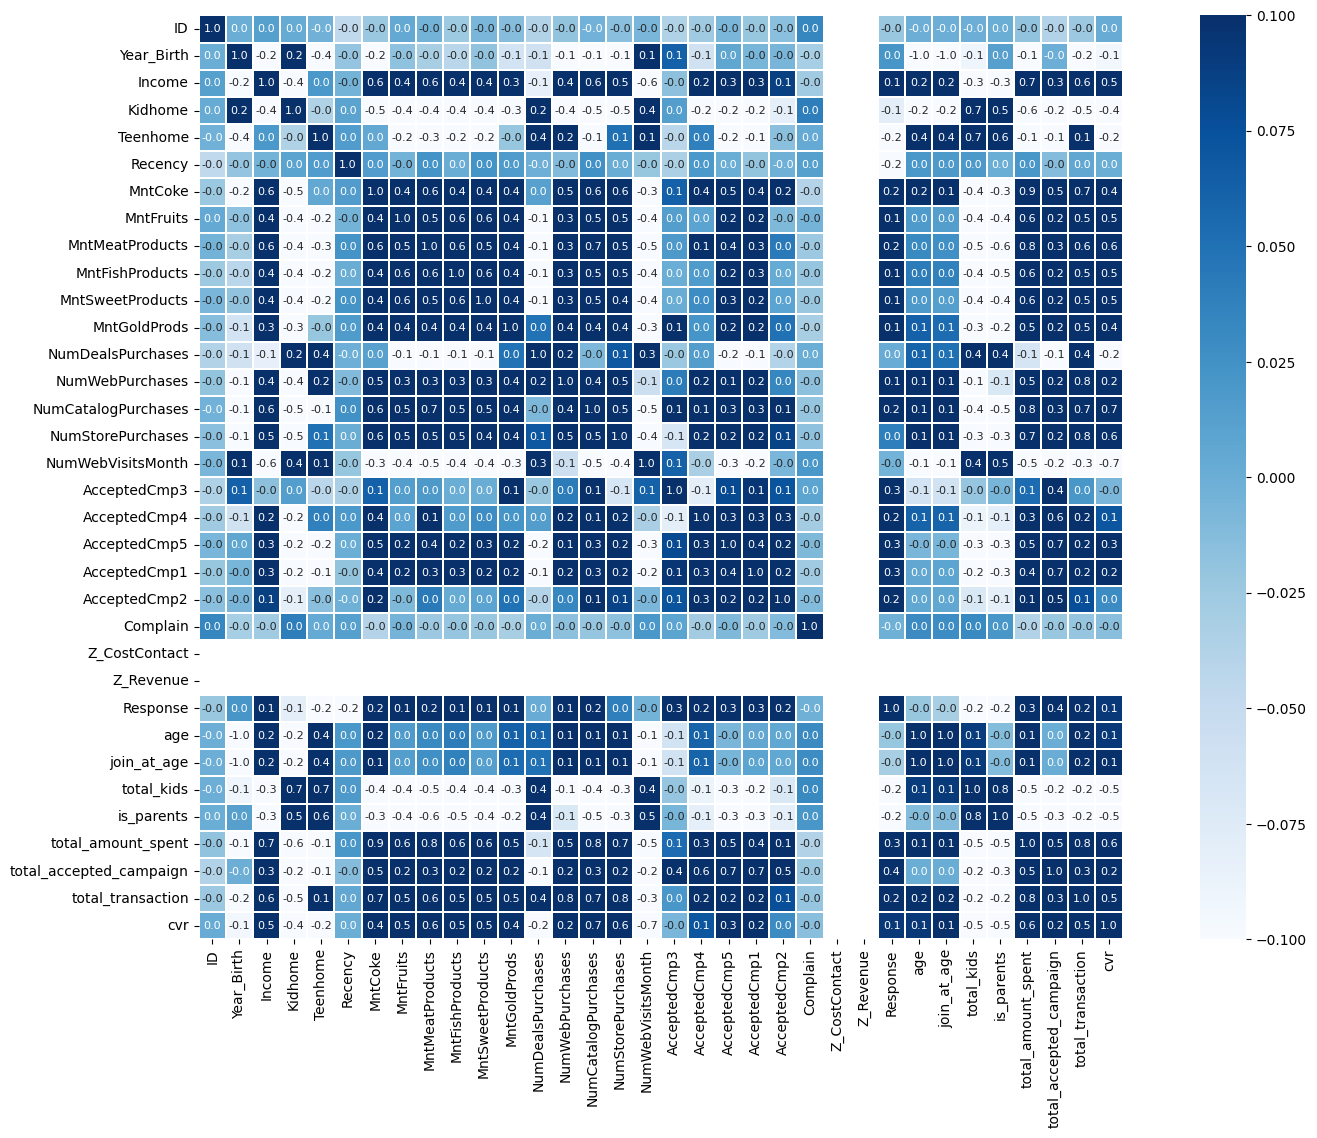

In [14]:
# correlation heatmap
plt.figure(figsize=(20, 12))
corrmat = df.corr()
sns.heatmap(corrmat, cmap='Blues', annot=True, fmt='.1f',
           vmin=corrmat.values.min(), vmax=1, square=True, linewidths=0.1, annot_kws={"fontsize":8})

### Income vs. Spending

(0.0, 120000000.0)

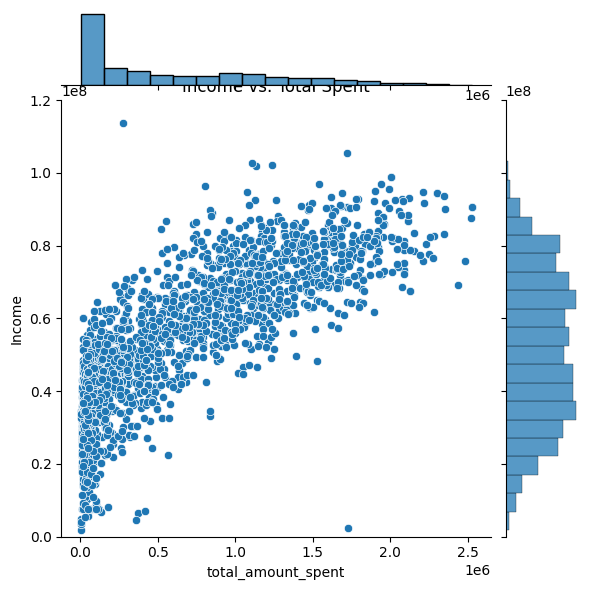

In [15]:
plot = sns.jointplot(x=df["total_amount_spent"], y=df["Income"])
plt.title('Income vs. Total Spent')
plot.ax_marg_y.set_ylim(0, 120000000)

### Income vs CVR

(0.0, 120000000.0)

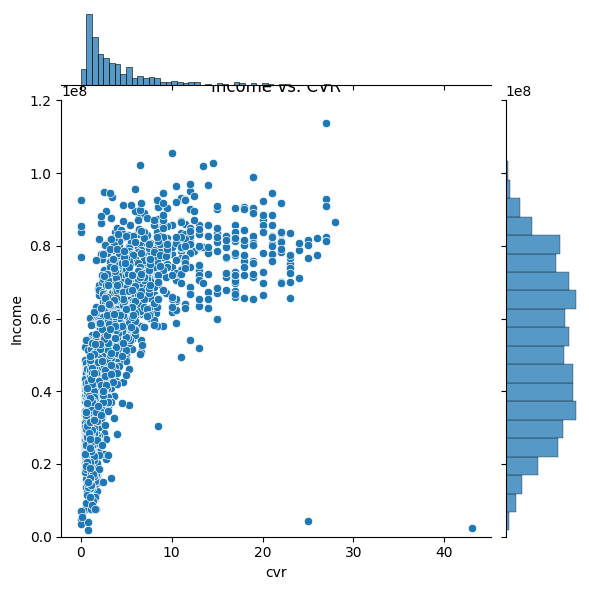

In [16]:
plot = sns.jointplot(x=df["cvr"], y=df["Income"])
plt.title('Income vs. CVR')
plot.ax_marg_y.set_ylim(0, 120000000)

### Age vs. Spending & Income

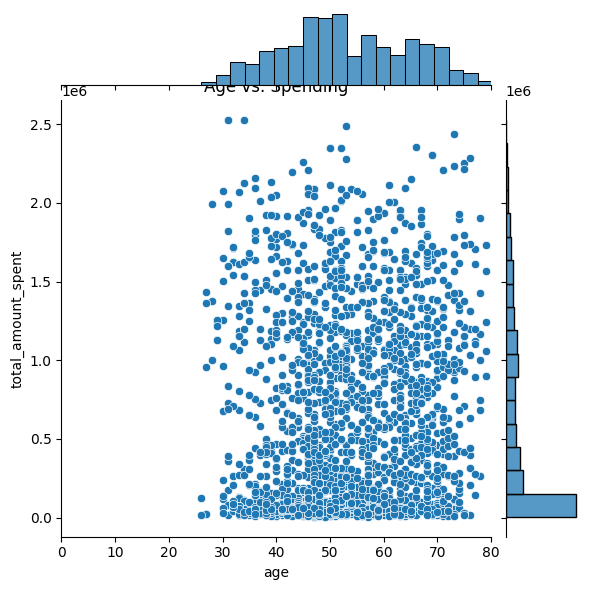

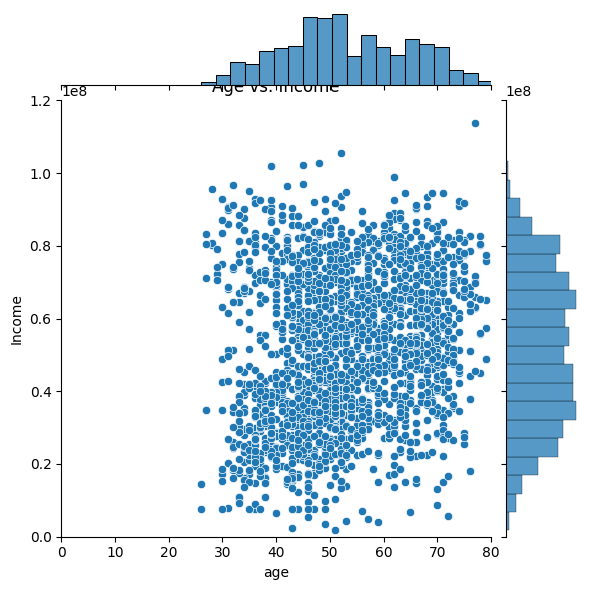

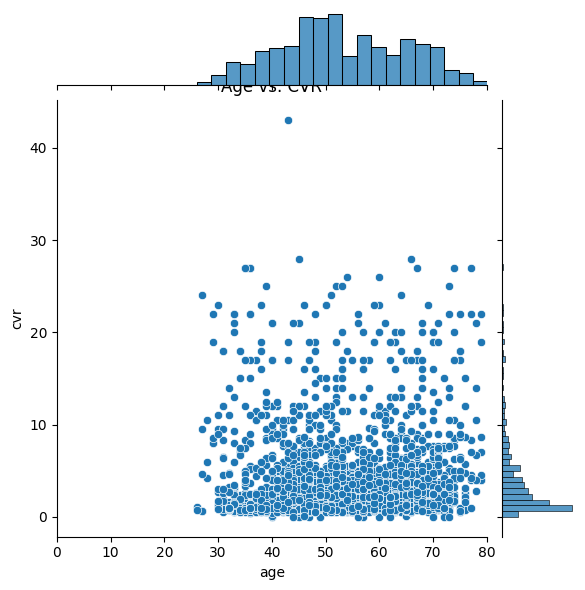

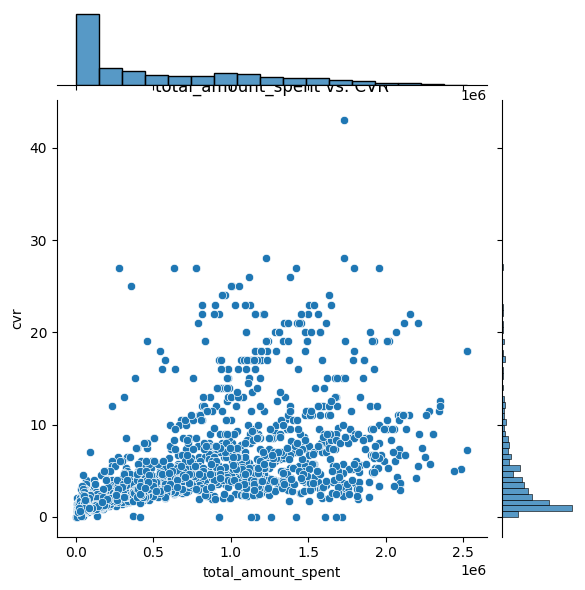

In [17]:
plot = sns.jointplot(x=df["age"], y=df["total_amount_spent"])
plt.title('Age vs. Spending')
plot.ax_marg_x.set_xlim(0, 80)
plt.show()

plot = sns.jointplot(x=df["age"], y=df["Income"])
plt.title('Age vs. Income')
plot.ax_marg_x.set_xlim(0, 80)
plot.ax_marg_y.set_ylim(0, 120000000)
plt.show()

plot = sns.jointplot(x=df["age"], y=df["cvr"])
plt.title('Age vs. CVR')
plot.ax_marg_x.set_xlim(0, 80)
plt.show()

plot = sns.jointplot(x=df["total_amount_spent"], y=df["cvr"])
plt.title('total_amount_spent vs. CVR')
# plot.ax_marg_x.set_xlim(0, 80)
plt.show()

Pada tahapan ini, menganalisis bagaimana hubungan antara feature conversion rate dengan Income ataupun age. Hasil dari eksplorasi data yang didapatkan, semakin besar income, terdapat kecenderungan untuk mempunyai pengeluaran lebih banyak dan mempunyai total pengeluaran yang lebih besar pula di platform kita. Hal ini tidak terlihat pada feature lain seperti age.

**Rekomendasi:** Kita dapat memilih customer yang mempunyai income 60 juta keatas untuk dilakukan marketing campaign dengan menargetkan banyak orang yang mempunyai CVR diatas 10%. Namun bagaimana dengan kelompok lainnya, dapatkah kita melakukan sesuatu kepada mereka?


## Mengatasi data null dan duplicated

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 0 to 2239
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       2240 non-null   int64         
 1   Year_Birth               2240 non-null   int64         
 2   Education                2240 non-null   object        
 3   Marital_Status           2240 non-null   object        
 4   Income                   2216 non-null   float64       
 5   Kidhome                  2240 non-null   int64         
 6   Teenhome                 2240 non-null   int64         
 7   Dt_Customer              2240 non-null   datetime64[ns]
 8   Recency                  2240 non-null   int64         
 9   MntCoke                  2240 non-null   int64         
 10  MntFruits                2240 non-null   int64         
 11  MntMeatProducts          2240 non-null   int64         
 12  MntFishProducts          2240 non-

In [19]:
df.isna().sum()

,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntCoke,0


In [20]:
df = df.dropna()

In [21]:
df.isna().sum()

,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,0
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntCoke,0


### Duplicate Rows

In [22]:
# Cek Data Duplicate
df.duplicated().sum()

0

In [23]:
df.shape

(2216, 38)

Tidak ditemukan Data Duplicate

## Melakukan feature encoding

In [24]:
# label encoder
edu = {
    'SMA' : 0,
    'D3' : 1,
    'S1' : 2,
    'S2' : 3,
    'S3' : 4
}

df['Education'] = df['Education'].map(edu)

In [25]:
#df_cats = df[['Education']].copy()
# One hot encoder
for cat in ['Marital_Status', 'age_range', 'is_parents']:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)

## Membuang data yang tidak diperlukan

In [ ]:
#df.drop(['Marital_Status', 'age_range','is_parents'],axis=1, inplace=True)
#df.info()

## Melakukan standardisasi pada feature

In [26]:
from sklearn.preprocessing import StandardScaler
dataset_scaled = df.copy()
ss = StandardScaler()

for col in numerical:
    dataset_scaled[col] = ss.fit_transform(dataset_scaled[[col]])

display(dataset_scaled.shape, dataset_scaled.head(3))

(2216, 49)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,...,Marital_Status_Cerai,Marital_Status_Duda,Marital_Status_Janda,Marital_Status_Lajang,Marital_Status_Menikah,age_range_middle_aged_adults,age_range_older_adults,age_range_young_adults,is_parents_0,is_parents_1
0,5524,1957,2,Lajang,0.234063,-0.823039,-0.928972,2012-04-09,0.310532,0.978226,...,0,0,0,1,0,0,1,0,1,0
1,2174,1954,2,Lajang,-0.234559,1.039938,0.909066,2014-08-03,-0.380509,-0.872024,...,0,0,0,1,0,0,1,0,0,1
2,4141,1965,2,Bertunangan,0.769478,-0.823039,-0.928972,2013-08-21,-0.795134,0.358511,...,0,0,0,0,0,0,1,0,1,0


# Data Modeling : K-means clustering

## Elbow Method

[105368.0794990943, 78937.5410539512, 62651.25849460162, 56882.68936203324, 51344.79339051414, 48014.219222974956, 44805.48722011465, 43444.09138643327, 42090.59806899682, 41031.72996745896, 40178.373760904455, 39261.20498255402, 38534.14539663577, 38000.74300654721, 35748.47696928354, 35101.25491355658, 34364.399893995964, 34276.649847904475]


<Axes: title={'center': 'Elbow Method of K-means Clustering'}>

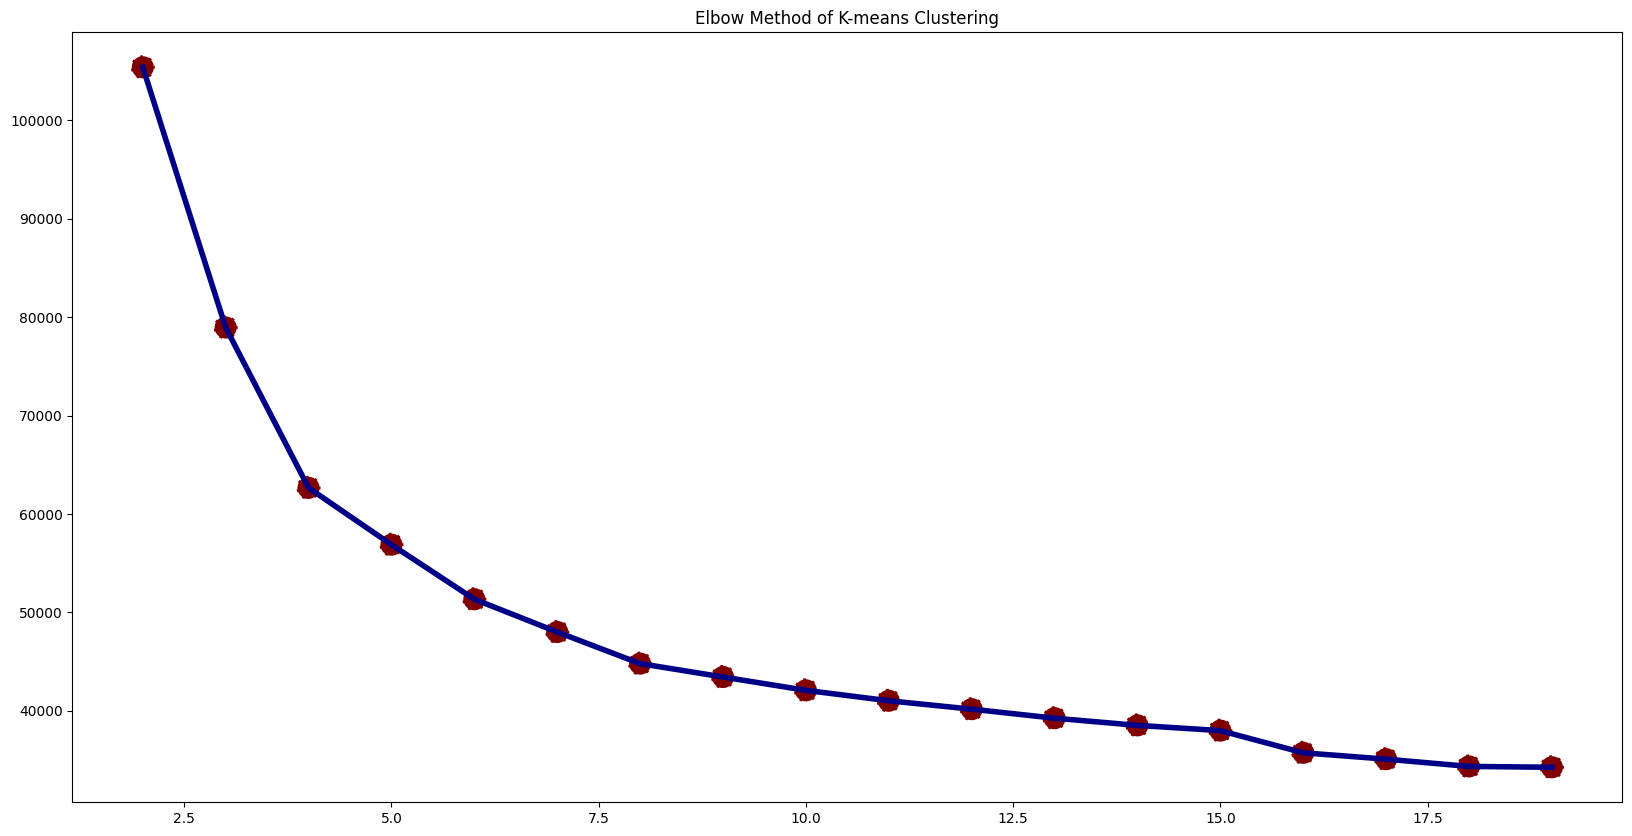

In [28]:
from sklearn.cluster import KMeans
X = dataset_scaled.drop(columns=['ID', 'Year_Birth', 'Education', 'Marital_Status', 'age_range',
                                 'Dt_Customer','is_parents']).copy()
#X = dataset_scaled
# X = dataset_scaled[numerical_features].copy()
inertia = []

for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X.values)
    inertia.append(kmeans.inertia_)

print(inertia)
plt.figure(figsize=(20, 10))
plt.title('Elbow Method of K-means Clustering')
# plt.plot(inertia)

sns.lineplot(x=range(2, 20), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 20), y=inertia, s=300, color='#800000',  linestyle='--')

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X.values)
X['cluster'] = kmeans.labels_
df['cluster'] = kmeans.labels_

<Axes: xlabel='total_amount_spent', ylabel='Income'>

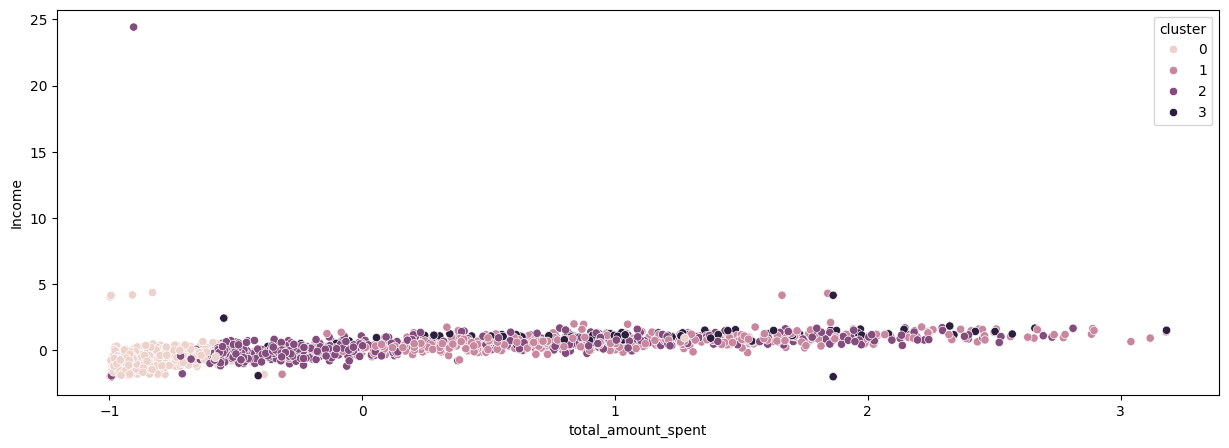

In [30]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=X, x='total_amount_spent', y='Income', hue='cluster')

## Eval: Silhouette Score

In [31]:
from sklearn.metrics import silhouette_score

def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.title('Silhouette Score of K-means Clustering')
    plt.show()

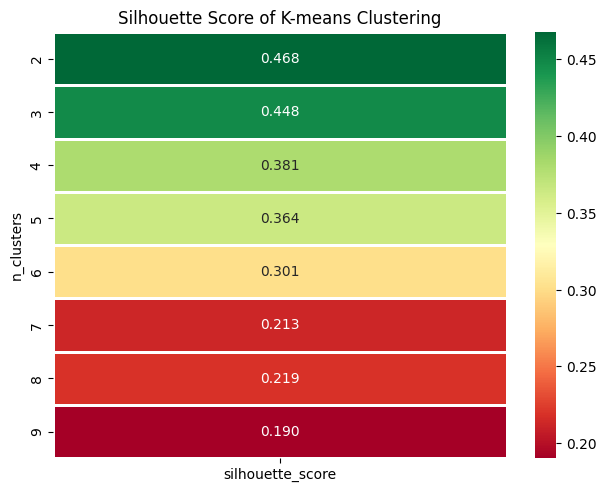

In [32]:
visualize_silhouette_layer(X)

### Insight
Analisis elbow method dan silhouette score dilakukan untuk melihat jumlah cluster yang didapat darialgoritma k-means clustering.

Pada grafik diatas, didapatkan jumlah cluster = 4 yang cukup dapat memisahkan masing-masing cluster dengan jarak yang paling optimal.

## Customer personality analysis for marketing retargeting

### Cluster Analysis & Interpretation

In [33]:
df[numerical+['cluster']].groupby('cluster')['Income','total_amount_spent'].describe()

Income                                                                 \
         count          mean           std        min         25%         50%   
cluster                                                                         
0        936.0  3.413432e+07  1.444471e+07  3502000.0  25099500.0  33566500.0   
1        502.0  6.835462e+07  1.329266e+07  7144000.0  60274500.0  67445000.0   
2        641.0  6.044246e+07  2.842059e+07  1730000.0  48432000.0  59111000.0   
3        137.0  7.863174e+07  1.416946e+07  2447000.0  72679000.0  80124000.0   

                                 total_amount_spent                \
                75%          max              count          mean   
cluster                                                             
0        41457250.0  162397000.0              936.0  7.997009e+04   
1        75883500.0  160803000.0              502.0  1.180855e+06   
2        70792000.0  666666000.0              641.0  7.816256e+05   
3        83829000.0  157146000.0              137.0  1.289168e+06   

                                                                             
                   std       min       25%        50%        75%        max  
cluster                                                                      
0         75657.892855    5000.0   37000.0    59000.0   100000.0  1376000.0  
1        427749.195231  416000.0  859000.0  1094000.0  1482000.0  2524000.0  
2        521501.794910    8000.0  388000.0   568000.0  1130000.0  2302000.0  
3        432624.303275  277000.0  988000.0  1216000.0  1574000.0  2525000.0

In [34]:
map_cluster = {
    0 : 'Low Spender',
    1 : 'Risk of Churn',
    2 : 'Mid Spender',
    3 : 'High Spender'
}

df['cluster_mapped'] = df['cluster'].map(map_cluster)

([0, 1, 2, 3],
 [Text(0, 0, 'Risk of Churn'),
  Text(1, 0, 'Low Spender'),
  Text(2, 0, 'Mid Spender'),
  Text(3, 0, 'High Spender')])

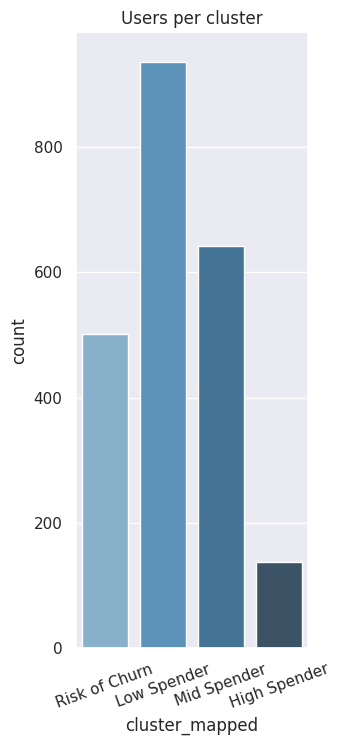

In [36]:
sns.set(rc={'figure.figsize':(3,8)})
sns.countplot(x=df['cluster_mapped'], palette='Blues_d')
plt.title('Users per cluster')
plt.xticks(rotation=20)

## Insight

1. Low Spender:
- Kelompok ini didominasi oleh older_adults (>55 tahun) dan middle_aged_adults (36-55 tahun), yang dominan telah menikah dan mempunyai 1 anak
- Kelompok ini mengunjungi website cukup sering, kedua tersering setelah Cluster 1, dengan median sebanyak 5 kali dalam sebulan, walaupun demikian, kelompok ini cukup sering mencari promo yang masing-masing orangnya membeli promo 2 kali dalam sebulan (median)
- Namun, kelompok ini mempunyai total pendapatan dan pengeluaran terkecil kedua dibandingkan Kelompok lainnya, yang masing-masing sebesar IDR 57 Juta untuk total pendapatan.


2. Risk of Churn:
- Kelompok ini adalah kelompok dengan jumlah user terbesar sebanyak 900 orang yang di dominasi oleh middle_aged_adults (3655 tahun), yang dominan telah menikah dan mempunyai 1 anak.
- Dari segi pendapatan dan pengeluaran, kelompok ini mempunyai pendapatan dan pengeluaran paling kecil di setiap bulannya, yang masing-masing sebesar IDR 33.4 Juta untuk total pendapatan setahun, dan IDR 57K untuk pengeluaran dalam setahun
- Walaupun demikian, kelompok ini adalah kelompok yang paling sering mengunjungi web dengan median total kunjungan 7 kali dalam sebulan, walaupun demikian, mereka masih jarang untuk bertransaksi dan bahkan menggunakan promo pada transaksinya.
- Secara campaign juga tidak banyak yang merespon dibandingkan dengan Kelompok lainnya. Mereka datang secara organic.

3. Mid Spender:
- Kelompok ini didominasi oleh older_adults (>55 tahun) dan middle_aged_adults (36-55 tahun), yang dominan telah menikah dan mempunyai 0-1 anak
- Kelompok ini mempunyai total pendapatan dan pengeluaran terbesar kedua dibandingkan Kelompok lainnya, yang masing-masing sebesar IDR 68 Juta untuk total pendapatan setahun, dan IDR 1.1 Juta untuk pengeluaran dalam setahun
- Walaupun cukup jarang untuk visit web, Kelompok ini adalah kelompok yang paling sering merespon campaign kita dan yang paling sering menggunakan promo dalam sebulannya dengan rata-rata penggunaan promo sebanyak 3 kali dalam sebulan

4. High Spender:
- Kelompok ini adalah kelompok dengan jumlah user terkecil sebanyak 137 orang yang di dominasi oleh older_adults (>55 tahun) dan middle_aged_adults (36-55 tahun), yang dominan telah belum/tidak menikah dan belum mempunyai anak.
- Dari segi pendapatan dan pengeluaran, kelompok ini mempunyai pendapatan dan pengeluaran paling besar di setiap bulannya, yang masing-masing sebesar IDR 80 Juta untuk total pendapatan setahun, dan IDR 1.2 Juta untuk pengeluaran dalam setahun
- Cluster ini cukup banyak yang merupakan non-organic dengan merespon campaign, namun memiliki jumlah penggunaan promo yang paling sedikit dibandingkan dengan yang lainnya.
- Kelompok ini adalah kelompok yang mempunyai conversion rate terbesar untuk membeli produk kita, dan kita jangan sampai kehilangan mereka.

(0.0, 120000000.0)

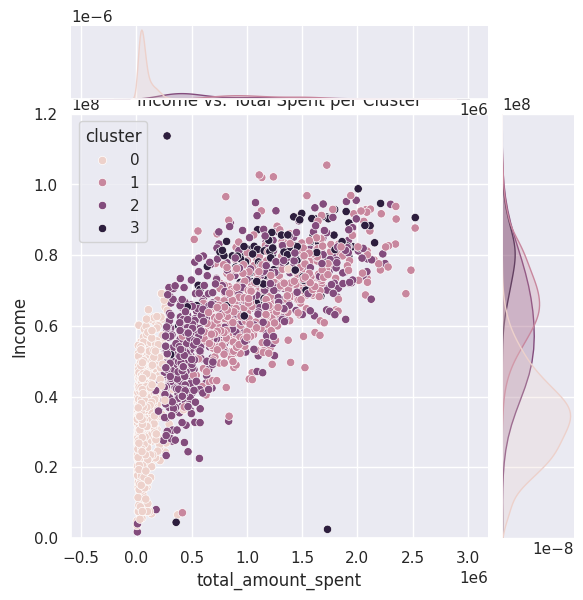

In [37]:
plot = sns.jointplot(x=df["total_amount_spent"], y=df["Income"], hue=df["cluster"])
plt.title('Income vs. Total Spent per Cluster')
plot.ax_marg_y.set_ylim(0, 120000000)

### Total Income per Cluster

(0.0, 120000000.0)

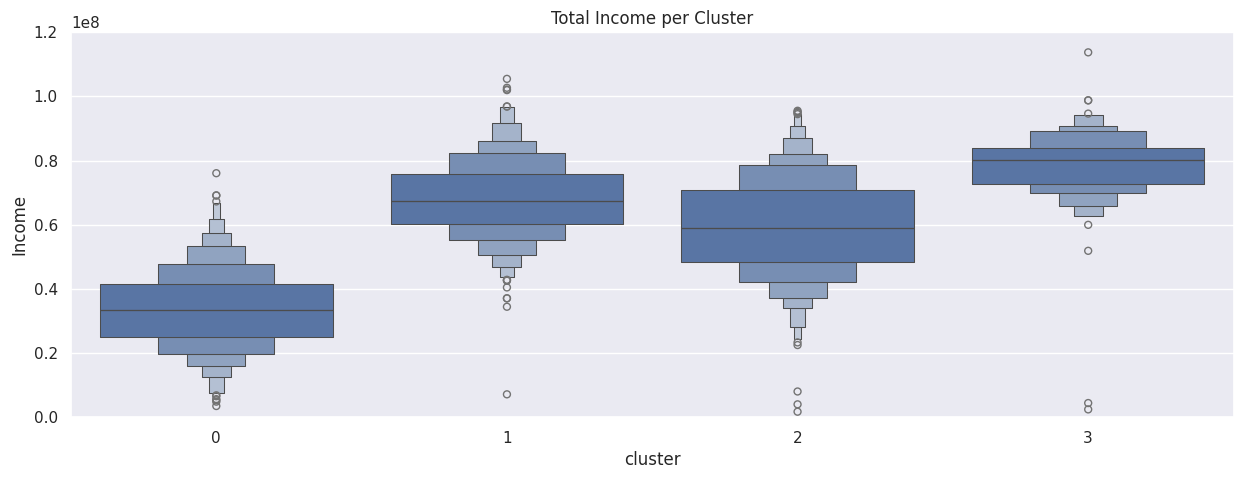

In [38]:
plt.figure(figsize=(15, 5))
sns.boxenplot(x=df['cluster'], y=df['Income'])
plt.title('Total Income per Cluster')
plt.ylim(0, 120000000)

### Total Spending per Cluster

Text(0.5, 1.0, 'Total Amount Spent per Cluster')

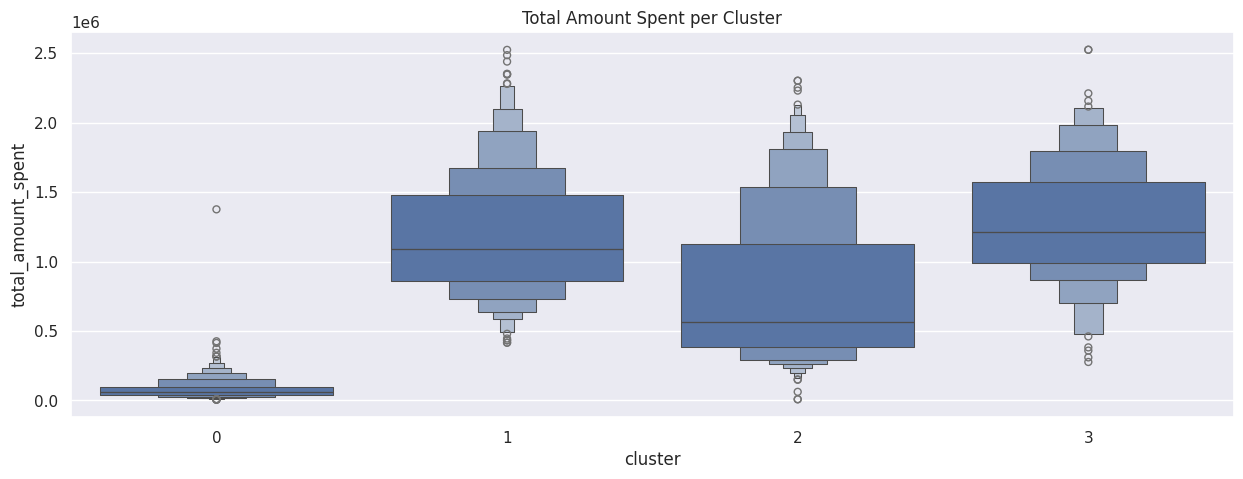

In [39]:
plt.figure(figsize=(15, 5))
sns.boxenplot(x=df['cluster'], y=df['total_amount_spent'])
plt.title('Total Amount Spent per Cluster')

### Total Visits per Cluster

Text(0.5, 1.0, 'Total Visit Web per Cluster')

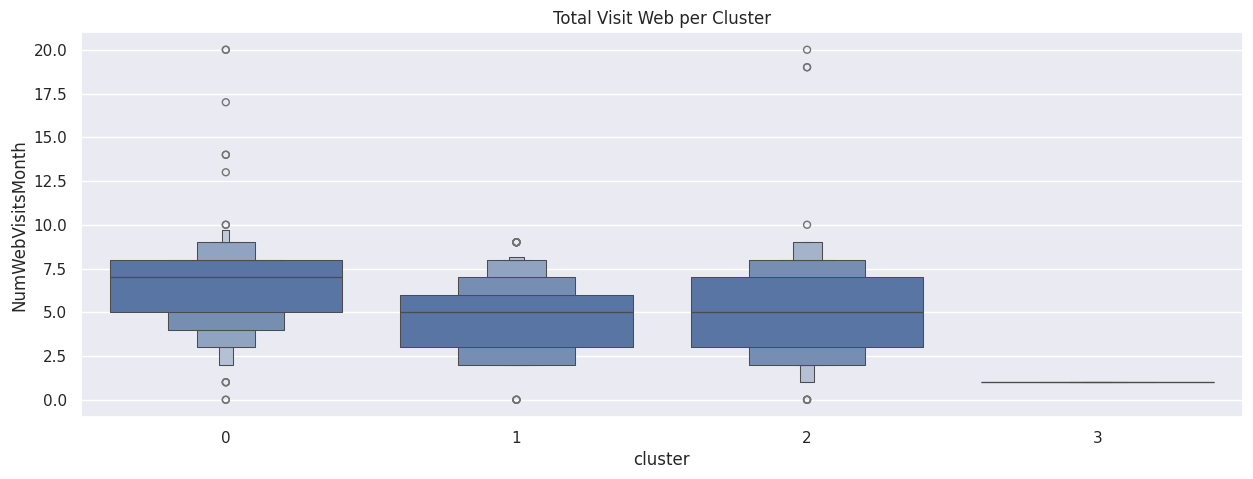

In [40]:
plt.figure(figsize=(15, 5))
sns.boxenplot(x=df['cluster'], y=df['NumWebVisitsMonth'])
plt.title('Total Visit Web per Cluster')

### Deal Puchased per Cluster

Text(0.5, 1.0, 'Deal Puchased per Cluster')

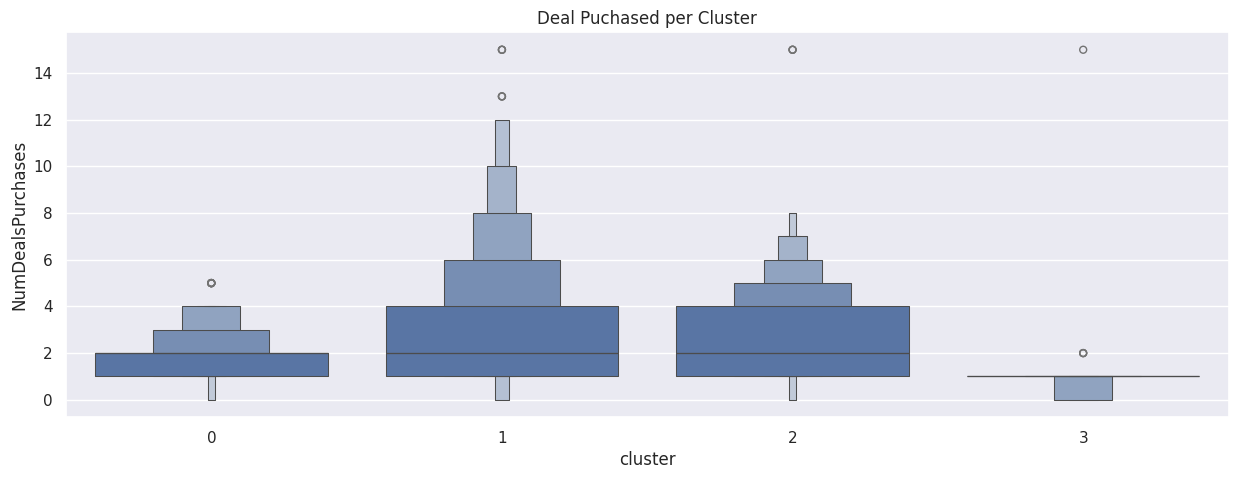

In [41]:
plt.figure(figsize=(15, 5))
sns.boxenplot(x=df['cluster'], y=df['NumDealsPurchases'])
plt.title('Deal Puchased per Cluster')

### Conversion per Cluster

Text(0.5, 1.0, 'CVR per Cluster')

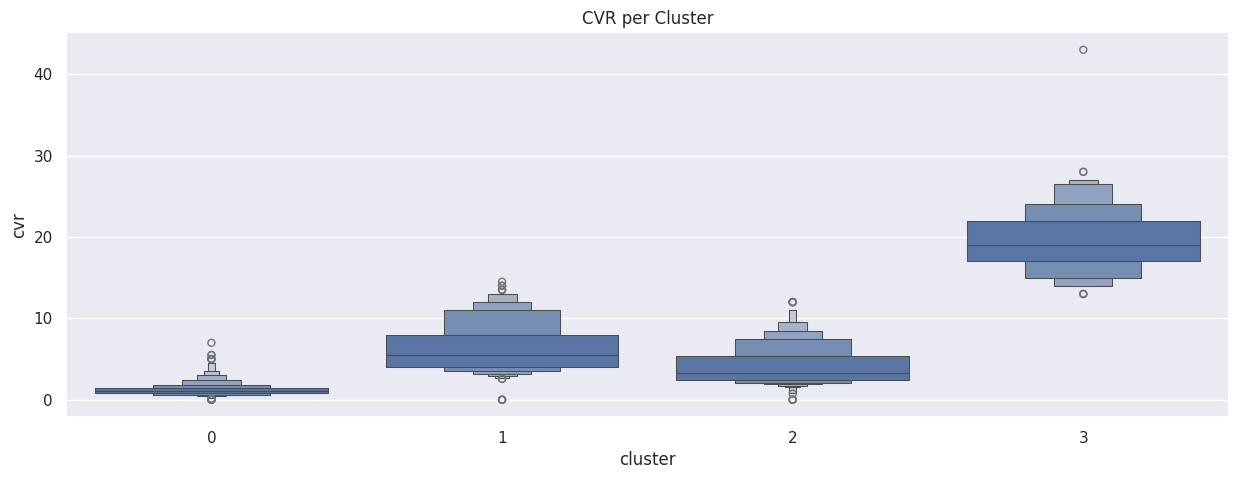

In [42]:
plt.figure(figsize=(15, 5))
sns.boxenplot(x=df['cluster'], y=df['cvr'])
plt.title('CVR per Cluster')

## Interpretasi Cluster

1. Low Spender:
- Kelompok ini didominasi oleh older_adults (>55 tahun) dan middle_aged_adults (36-55 tahun), yang dominan telah menikah dan mempunyai 1 anak
- Kelompok ini mengunjungi website cukup sering, kedua tersering setelah Cluster 1, dengan median sebanyak 5 kali dalam sebulan, walaupun demikian, kelompok ini cukup sering mencari promo yang masing-masing orangnya membeli promo 2 kali dalam sebulan (median)
- Namun, kelompok ini mempunyai total pendapatan dan pengeluaran terkecil kedua dibandingkan Kelompok lainnya, yang masing-masing sebesar IDR 57 Juta untuk total pendapatan setahun, dan IDR 506K untuk pengeluaran dalam setahun


2. Risk of Churn:
- Kelompok ini adalah kelompok dengan jumlah user terbesar sebanyak 900 orang yang di dominasi oleh middle_aged_adults (36-55 tahun), yang dominan telah menikah dan mempunyai 1 anak.
- Dari segi pendapatan dan pengeluaran, kelompok ini mempunyai pendapatan dan pengeluaran paling kecil di setiap bulannya, yang masing-masing sebesar IDR 33.4 Juta untuk total pendapatan setahun, dan IDR 57K untuk pengeluaran dalam setahun
- Walaupun demikian, kelompok ini adalah kelompok yang paling sering mengunjungi web dengan median total kunjungan 7 kali dalam sebulan, walaupun demikian, mereka masih jarang untuk bertransaksi dan bahkan menggunakan promo pada transaksinya
- Secara campaign juga tidak banyak yang merespon dibandingkan dengan Kelompok lainnya. Mereka datang secara organic


3. Mid Spender:
- Kelompok ini didominasi oleh older_adults (>55 tahun) dan middle_aged_adults (36-55 tahun), yang dominan telah menikah dan mempunyai 0-1 anak
- elompok ini mempunyai total pendapatan dan pengeluaran terbesar kedua dibandingkan Kelompok lainnya, yang masing-masing sebesar IDR 68 Juta untuk total pendapatan setahun, dan IDR 1.1 Juta untuk pengeluaran dalam setahun
- Walaupun cukup jarang untuk visit web, Kelompok ini adalah kelompok yang paling sering merespon campaign kita dan yang paling sering menggunakan promo dalam sebulannya dengan rata-rata penggunaan promo sebanyak 3 kali dalam sebulan


4. High Spender:
- Kelompok ini adalah kelompok dengan jumlah user terkecil sebanyak 137 orang yang di dominasi oleh older_adults (>55 tahun) dan middle_aged_adults (36-55 tahun), yang dominan telah belum/tidak menikah dan belum mempunyai anak
- Dari segi pendapatan dan pengeluaran, kelompok ini mempunyai pendapatan dan pengeluaran paling besar di setiap bulannya, yang masing-masing sebesar IDR 80 Juta untuk total pendapatan setahun, dan IDR 1.2 Juta untuk pengeluaran dalam setahun
- Cluster ini cukup banyak yang merupakan non-organic dengan merespon campaign, namun memiliki jumlah penggunaan promo yang paling sedikit dibandingkan dengan yang lainnya.
- Kelompok ini adalah kelompok yang mempunyai conversion rate terbesar untuk membeli produk kita, dan kita jangan sampai kehilangan mereka.

### Recommendation & Potential Impact

Recommendation:
1. Tetap monitor transaksi dan retensi dari kelompok High Spender, Fokus untuk tingkatkan service agar kelompok kelompok ini tidak churn
2. Untuk kelompok Mid Spender dapat dilakukan analisis lebih lanjut bagaimana agar meningkatkan transaksinya dengan memberikan rekomendasi yang lebih personal, serta analisis lebih dalam bagaimana untuk optimasi promo pada segmen ini dan tetap berbelanja di platform kita
3. Untuk kelompok Low Spender dan Risk to Churn, juga dapat dilakukan analisis lebih lanjut bagaimana meningkatkan rasio konversi visit to transaction, Mereka mempunyai jumlah visit yang cukup tinggi tapi tidak melakukan transaksi. Hal ini dapat disebabkan oleh produk ataupun harga yang tidak cocok.

Potential Impact:
- Jika kita fokus untuk terus monitor kelompok High Spender, kita akan tetap mendapatkan potensial GMV sebesar IDR 176 Juta, sedangkan untuk kelompok Mid Spender sebesar IDR 66 Juta
- Jika kita dapat optimasi promo yang di spend untuk Mid Spender (dengan asumsi reduksi 50%)m kita dapat melakukan reduksi cost seevsar IDR 50 Juta